# Comparing AlexNet and VGG16 on `cars196`
## Importing Libraries

In [ ]:
import os
import shutil
from typing import Literal, Union
import random

import numpy as np
import pandas as pd
import seaborn as sns
import torch
from keras.applications import VGG16
from keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
)
from keras.models import Model, Sequential
from keras.optimizers.legacy import Adam
from keras.preprocessing.image import ImageDataGenerator
from torchvision.models import alexnet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Cleaning and Processing
### Data Cleaning
- Sort images by manufacturer instead of model
- Filter the manufacturers

In [ ]:
# Set to FALSE if running on Google Colab
local_runtime = False

# Path setup (adjust these as necessary)
original_path = "/content/drive/MyDrive/dataset/manufacturers"
new_path = "/content/drive/MyDrive/dataset/manufacturers_split"

# Ensure the main directory exists
os.makedirs(new_path, exist_ok=True)

# Create 'train' and 'test' directories if they don't exist
for split in ["train", "test"]:
    dest_split_path = os.path.join(new_path, split)
    os.makedirs(dest_split_path, exist_ok=True)

train_dir = "/content/drive/MyDrive/dataset/manufacturers_split/train"
test_dir = "/content/drive/MyDrive/dataset/manufacturers_split/test"

selected_manufacturers = [
    "audi",
    "bmw",
    "chevrolet",
    "ford",
    "honda",
    "hyundai",
    "mercedes-benz",
    "nissan",
    "toyota",
    "volkswagen",
]

# Set a random seed for reproducibility
random_seed = 42
random.seed(random_seed)

# Process each car manufacturer directory inside the original data folder
for split in ["train", "test"]:
    split_path = os.path.join(original_path, split)
    if not os.path.exists(split_path):
        print(f"{split_path} does not exist.")
        continue

    for car_dir in os.listdir(split_path):
        if car_dir.startswith("."):
            continue

        manufacturer = car_dir.lower()

        # Filter only the selected manufacturers
        if manufacturer not in selected_manufacturers:
            continue

        # Paths for original, train, and test data
        source_car_path = os.path.join(split_path, car_dir)

        images = [img for img in os.listdir(source_car_path) if img.endswith(".jpg")]

        if not images:
            continue

        random.shuffle(images)

        split_point = int(len(images) * 0.8)
        train_images = images[:split_point]
        test_images = images[split_point:]

        train_manufacturer_path = os.path.join(new_path, 'train', manufacturer)
        test_manufacturer_path = os.path.join(new_path, 'test', manufacturer)

        os.makedirs(train_manufacturer_path, exist_ok=True)
        os.makedirs(test_manufacturer_path, exist_ok=True)

        for image in train_images:
            source_image_path = os.path.join(source_car_path, image)
            dest_image_path = os.path.join(train_manufacturer_path, image)
            shutil.copy2(source_image_path, dest_image_path)

        for image in test_images:
            source_image_path = os.path.join(source_car_path, image)
            dest_image_path = os.path.join(test_manufacturer_path, image)
            shutil.copy2(source_image_path, dest_image_path)

        print(f"{manufacturer.capitalize()} - Train: {len(train_images)}, Test: {len(test_images)}")


def filter_manufacturers(
    directory: str,
    manufacturers: list[str],
    datagen: ImageDataGenerator,
    target_size: tuple[int, int],
    batch_size: int,
    class_mode: Union[Literal["categorical"], Literal["sparse"], Literal["binary"]],
):
    all_classes = [
        d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))
    ]
    filtered_classes = [c for c in all_classes if c in manufacturers]

    return datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=batch_size,
        classes=filtered_classes,
        class_mode=class_mode,
    )


Audi - Train: 471, Test: 118
Bmw - Train: 424, Test: 107
Chevrolet - Train: 724, Test: 181
Hyundai - Train: 350, Test: 88
Ford - Train: 416, Test: 105
Honda - Train: 128, Test: 33
Mercedes-benz - Train: 208, Test: 53
Nissan - Train: 136, Test: 35
Volkswagen - Train: 105, Test: 27
Toyota - Train: 134, Test: 34
Audi - Train: 464, Test: 116
Bmw - Train: 419, Test: 105
Chevrolet - Train: 715, Test: 179
Ford - Train: 411, Test: 103
Honda - Train: 128, Test: 32
Hyundai - Train: 346, Test: 87
Mercedes-benz - Train: 205, Test: 52
Nissan - Train: 136, Test: 34
Toyota - Train: 131, Test: 33
Volkswagen - Train: 104, Test: 27


### Split and Ready Data
- Split data using ImageDataGenerator
- Define data augmentators for each model


In [ ]:
# Image data generators for loading and augmenting images
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

input_shape_vgg16 = (224, 224, 3)
input_shape_alexnet = (227, 227, 3)
batch_size = 32

train_generator_vgg16 = filter_manufacturers(
    train_dir,
    selected_manufacturers,
    train_datagen,
    target_size=input_shape_vgg16[:2],
    batch_size=batch_size,
    class_mode="categorical",
)

test_generator_vgg16 = filter_manufacturers(
    test_dir,
    selected_manufacturers,
    test_datagen,
    target_size=input_shape_vgg16[:2],
    batch_size=batch_size,
    class_mode="categorical",
)

train_generator_alexnet = filter_manufacturers(
    train_dir,
    selected_manufacturers,
    train_datagen,
    target_size=input_shape_alexnet[:2],
    batch_size=batch_size,
    class_mode="categorical",
)

test_generator_alexnet = filter_manufacturers(
    test_dir,
    selected_manufacturers,
    test_datagen,
    target_size=input_shape_alexnet[:2],
    batch_size=batch_size,
    class_mode="categorical",
)

Found 6059 images belonging to 10 classes.
Found 1616 images belonging to 10 classes.
Found 6059 images belonging to 10 classes.
Found 1616 images belonging to 10 classes.


### Basic EDA


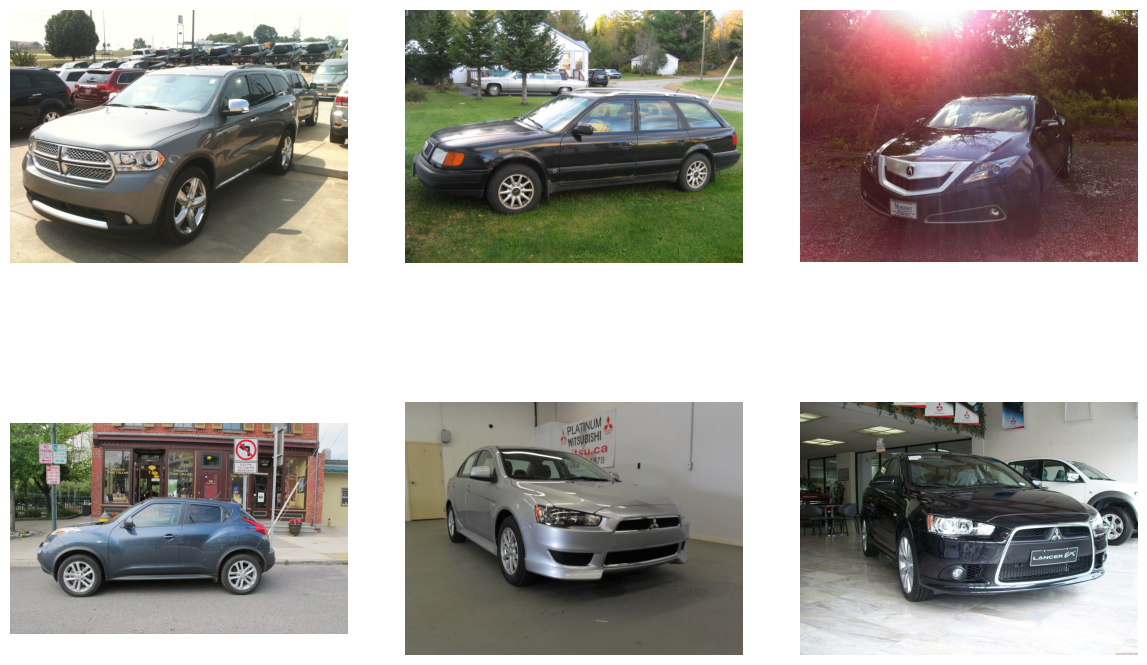

In [ ]:
#Displaying 6 random images without labels

from google.colab.patches import cv2_imshow
import cv2
import os
import random
import matplotlib.pyplot as plt

# Set the directory containing the images in the "train" folder
train_image_dir = "/content/drive/MyDrive/dataset/manufacturers/train"

# Collect all image file paths in the "train" folder
train_image_files = []
for root, dirs, files in os.walk(train_image_dir):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            train_image_files.append(os.path.join(root, file))

# Randomly select 6 images from the "train" folder
selected_train_images = random.sample(train_image_files, 6)

# Number of rows and columns in the grid
rows, cols = 2, 3

# Create a figure and axis objects
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
fig.tight_layout()

# Display each selected image in the grid
for ax, image_path in zip(axes.flatten(), selected_train_images):
    # Load the image
    image = cv2.imread(image_path)
    # Convert BGR to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Display the image
    ax.imshow(image_rgb)
    # Remove axis
    ax.axis('off')

# Show the grid
plt.show()


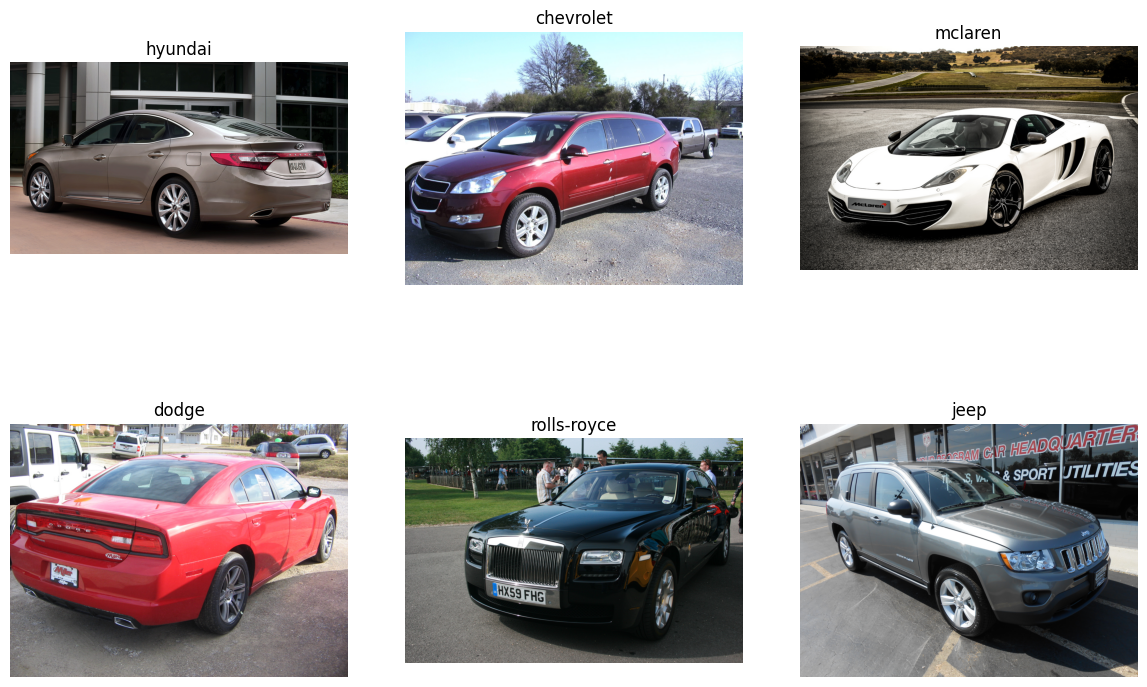

In [ ]:
#Displaying 6 random images with labels

from google.colab.patches import cv2_imshow
import cv2
import os
import random
import matplotlib.pyplot as plt

# Set the directory containing the images in the "train" folder
train_image_dir = "/content/drive/MyDrive/dataset/manufacturers/train"

# Collect all image file paths in the "train" folder
train_image_files = []
for root, dirs, files in os.walk(train_image_dir):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            train_image_files.append(os.path.join(root, file))

# Randomly select 6 images from the "train" folder
selected_train_images = random.sample(train_image_files, 6)

# Number of rows and columns in the grid
rows, cols = 2, 3

# Creating the figure
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
fig.tight_layout()

# Display each selected image in the grid
for ax, image_path in zip(axes.flatten(), selected_train_images):
    # Load the image
    image = cv2.imread(image_path)
    # Convert BGR to RGB for displaying with matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Display the image
    ax.imshow(image_rgb)
    # Extract the label from the directory structure
    label = os.path.basename(os.path.dirname(image_path))
    # Set the title with the label
    ax.set_title(label)
    # Hide the axis
    ax.axis('off')

# Display the grid
plt.show()


In [ ]:
def count_images(directory, classes):
    """
    Count the number of images in each class directory.
    """
    counts = {}
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        if os.path.exists(class_path):
            image_files = [file for file in os.listdir(class_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]
            counts[class_name] = len(image_files)
        else:
            counts[class_name] = 0
    return counts

# Count images in train and test directories
train_counts = count_images(train_dir, selected_manufacturers)
test_counts = count_images(test_dir, selected_manufacturers)

# Display the counts
print("Train Dataset Image Counts:")
for manufacturer, count in train_counts.items():
    print(f"{manufacturer}: {count}")

print("\nTest Dataset Image Counts:")
for manufacturer, count in test_counts.items():
    print(f"{manufacturer}: {count}")


Train Dataset Image Counts:
audi: 903
bmw: 824
chevrolet: 1371
ford: 805
honda: 253
hyundai: 756
mercedes-benz: 409
nissan: 270
toyota: 262
volkswagen: 206

Test Dataset Image Counts:
audi: 234
bmw: 211
chevrolet: 355
ford: 208
honda: 65
hyundai: 248
mercedes-benz: 105
nissan: 69
toyota: 67
volkswagen: 54


## Define and Run Models

### VGG16 with Pre-trained Weights

In [ ]:
base_model_vgg16i = VGG16(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)

x_vgg16i = base_model_vgg16i.output
x_vgg16i = Flatten()(x_vgg16i)
x_vgg16i = Dense(512, activation="relu")(x_vgg16i)
x_vgg16i = Dropout(0.5)(x_vgg16i)
predictions_vgg16i = Dense(train_generator_vgg16.num_classes, activation="softmax")(
    x_vgg16i
)

model_vgg16i = Model(inputs=base_model_vgg16i.input, outputs=predictions_vgg16i)

for layer in base_model_vgg16i.layers:
    layer.trainable = False

model_vgg16i.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model_vgg16i.fit(train_generator_vgg16, epochs=10, validation_data=test_generator_vgg16)

for layer in base_model_vgg16i.layers[-4:]:
    layer.trainable = True

model_vgg16i.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model_vgg16i.fit(train_generator_vgg16, epochs=10, validation_data=test_generator_vgg16)

loss_vgg16i, accuracy_vgg16i = model_vgg16i.evaluate(test_generator_vgg16)
print(f"Test accuracy: {accuracy_vgg16i * 100:.2f}%")


if local_runtime:
    model_vgg16i.save("vgg16i.keras")

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
188/188 [==============================] - 4421s 24s/step - loss: 2.1561 - accuracy: 0.2328 - val_loss: 1.9248 - val_accuracy: 0.3441
Epoch 2/10
 90/188 [=============>................] - ETA: 30:16 - loss: 2.0140 - accuracy: 0.2931

KeyboardInterrupt: 

### VGG16 without Pre-trained Weights

In [ ]:
# Build self-defined VGG16 model
def build_vgg16d(input_shape: tuple[int, int, int], num_classes: int) -> Sequential:
    model = Sequential()

    model.add(
        Conv2D(64, (3, 3), activation="relu", padding="same", input_shape=input_shape)
    )
    model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
    model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(256, (3, 3), activation="relu", padding="same"))
    model.add(Conv2D(256, (3, 3), activation="relu", padding="same"))
    model.add(Conv2D(256, (3, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), activation="relu", padding="same"))
    model.add(Conv2D(512, (3, 3), activation="relu", padding="same"))
    model.add(Conv2D(512, (3, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), activation="relu", padding="same"))
    model.add(Conv2D(512, (3, 3), activation="relu", padding="same"))
    model.add(Conv2D(512, (3, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))

    return model


num_samples_vgg16d = train_generator_vgg16.samples
steps_per_epoch_vgg16d = num_samples_vgg16d // batch_size
num_classes_vgg16d = train_generator_vgg16.num_classes

model_vgg16d = build_vgg16d(input_shape_vgg16, num_classes_vgg16d)

model_vgg16d.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model_vgg16d.fit(
    train_generator_vgg16,
    steps_per_epoch=steps_per_epoch_vgg16d,
    epochs=10,
    validation_data=test_generator_vgg16,
)

model_vgg16d.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model_vgg16d.fit(
    train_generator_vgg16,
    steps_per_epoch=steps_per_epoch_vgg16d,
    epochs=10,
    validation_data=test_generator_vgg16,
)

loss_vgg16d, accuracy_vgg16d = model_vgg16d.evaluate(test_generator_vgg16)
print(f"Test accuracy: {accuracy_vgg16d * 100:.2f}%")


if local_runtime:
    model_vgg16d.save("vgg16d.keras")

Epoch 1/10
1/1 [==============================] - 724s 724s/step - loss: 2.3024 - accuracy: 0.0938 - val_loss: 2.3077 - val_accuracy: 0.0027
Epoch 2/10
1/1 [==============================] - 665s 665s/step - loss: 2.2932 - accuracy: 0.1667 - val_loss: 2.3429 - val_accuracy: 0.0027
Epoch 3/10
1/1 [==============================] - 741s 741s/step - loss: 2.2693 - accuracy: 0.3333 - val_loss: 2.4318 - val_accuracy: 0.0027
Epoch 4/10
1/1 [==============================] - 710s 710s/step - loss: 2.1970 - accuracy: 0.1875 - val_loss: 2.9047 - val_accuracy: 0.0027
Epoch 5/10
1/1 [==============================] - 709s 709s/step - loss: 2.0606 - accuracy: 0.2500 - val_loss: 3.4206 - val_accuracy: 0.0027
Epoch 6/10
1/1 [==============================] - 689s 689s/step - loss: 2.1366 - accuracy: 0.3125 - val_loss: 2.6359 - val_accuracy: 0.0027
Epoch 7/10
1/1 [==============================] - 657s 657s/step - loss: 2.0798 - accuracy: 0.0833 - val_loss: 2.3806 - val_accuracy: 0.0071
Epoch 8/10
1/

### AlexNet with Pre-trained Weights

In [ ]:
model_alexneti = alexnet(weights="DEFAULT")

torch.save(model_alexneti.state_dict(), "alexnet_pytorch.pth")
os.makedirs("torch_alexnet_weights", exist_ok=True)
model_weights = torch.load("alexnet_pytorch.pth")

for key in model_weights.keys():
    parts = key.split(".")
    layer_name = parts[0] + "_" + parts[1]
    param_type = parts[-1]
    param_name = "weight" if param_type == "weight" else "bias"

    # Transpose the convolutional weights from (out_channels, in_channels, kernel_height, kernel_width) to (kernel_height, kernel_width, in_channels, out_channels) for Keras
    if "features" in key and "weight" in key:
        weights = model_weights[key].numpy().transpose(2, 3, 1, 0)
    # Transpose the dense weights from (out_features, in_features) to (in_features, out_features) for Keras
    elif "classifier" in key and "weight" in key:
        weights = model_weights[key].numpy().transpose()
    else:
        weights = model_weights[key].numpy()

    np.save(f"torch_alexnet_weights/{layer_name}_{param_name}.npy", weights)


def build_alexneti(input_shape: tuple[int, int, int]) -> Sequential:
    model = Sequential()
    model.add(
        Conv2D(
            64,
            (11, 11),
            strides=(4, 4),
            padding="same",
            input_shape=input_shape,
            name="conv2d_0",
        )
    )
    model.add(Activation("relu"))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), name="maxpool2d_0"))

    model.add(Conv2D(192, (5, 5), padding="same", name="conv2d_1"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), name="maxpool2d_1"))

    model.add(Conv2D(384, (3, 3), padding="same", name="conv2d_2"))
    model.add(Activation("relu"))

    model.add(Conv2D(256, (3, 3), padding="same", name="conv2d_3"))
    model.add(Activation("relu"))

    model.add(Conv2D(256, (3, 3), padding="same", name="conv2d_4"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), name="maxpool2d_2"))

    model.add(Flatten())
    model.add(Dense(4096, name="dense_0"))
    model.add(Activation("relu"))
    model.add(Dropout(0.5, name="dropout_0"))

    model.add(Dense(4096, name="dense_1"))
    model.add(Activation("relu"))
    model.add(Dropout(0.5, name="dropout_1"))

    model.add(Dense(1000, name="dense_2"))
    model.add(Activation("softmax"))

    return model


num_samples_alexneti = train_generator_alexnet.samples
steps_per_epoch_alexneti = num_samples_alexneti // 32
num_classes_alexneti = train_generator_alexnet.num_classes

model_alexneti = build_alexneti(input_shape_alexnet)

layer_mapping = {
    "conv2d_0": "features_0",
    "conv2d_1": "features_3",
    "conv2d_2": "features_6",
    "conv2d_3": "features_8",
    "conv2d_4": "features_10",
    "dense_0": "classifier_1",
    "dense_1": "classifier_4",
    "dense_2": "classifier_6",
}

for layer in model_alexneti.layers:
    if isinstance(layer, Conv2D) or isinstance(layer, Dense):
        layer_name = layer.name
        mapped_name = layer_mapping[layer_name]
        weights = np.load(f"torch_alexnet_weights/{mapped_name}_weight.npy")
        biases = np.load(f"torch_alexnet_weights/{mapped_name}_bias.npy")
        layer.set_weights([weights, biases])
    elif isinstance(layer, BatchNormalization):
        layer_name = layer.name
        mapped_name = layer_mapping[layer_name]
        gamma = np.load(f"torch_alexnet_weights/{mapped_name}_weight.npy")
        beta = np.load(f"torch_alexnet_weights/{mapped_name}_bias.npy")
        moving_mean = np.load(f"torch_alexnet_weights/{mapped_name}_running_mean.npy")
        moving_variance = np.load(
            f"torch_alexnet_weights/{mapped_name}_running_var.npy"
        )
        layer.set_weights([gamma, beta, moving_mean, moving_variance])

model_alexneti.layers.pop()
model_alexneti.add(Dense(num_classes_alexneti, activation="softmax", name="output"))


model_alexneti.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model_alexneti.fit(
    train_generator_alexnet,
    steps_per_epoch=steps_per_epoch_alexneti,
    epochs=10,
    validation_data=test_generator_alexnet,
)

model_alexneti.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model_alexneti.fit(
    train_generator_alexnet,
    steps_per_epoch=steps_per_epoch_alexneti,
    epochs=10,
    validation_data=test_generator_alexnet,
)

loss_alexneti, accuracy_alexneti = model_alexneti.evaluate(test_generator_alexnet)
print(f"Test accuracy: {accuracy_alexneti * 100:.2f}%")


if local_runtime:
    model_alexneti.save("alexneti.keras")


### AlexNet without Pre-trained Weights

In [ ]:
def build_alexnetd(input_shape: tuple[int, int, int], num_classes: int) -> Sequential:
    model = Sequential()
    model.add(
        Conv2D(
            96,
            (11, 11),
            strides=(4, 4),
            padding="same",
            activation="relu",
            input_shape=input_shape,
        )
    )
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (5, 5), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(384, (3, 3), padding="same", activation="relu"))
    model.add(Conv2D(384, (3, 3), padding="same", activation="relu"))
    model.add(Conv2D(256, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))

    return model


num_samples_alexnetd = train_generator_alexnet.samples
steps_per_epoch_alexnetd = num_samples_alexnetd // batch_size
num_classes_alexnetd = train_generator_alexnet.num_classes

model_alexnetd = build_alexnetd(
    input_shape_alexnet, train_generator_alexnet.num_classes
)

model_alexnetd.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model_alexnetd.fit(
    train_generator_alexnet,
    steps_per_epoch=steps_per_epoch_alexnetd,
    epochs=10,
    validation_data=test_generator_alexnet,
)

model_alexnetd.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model_alexnetd.fit(
    train_generator_alexnet,
    steps_per_epoch=steps_per_epoch_alexnetd,
    epochs=10,
    validation_data=test_generator_alexnet,
)

loss_alexnetd, accuracy_alexnetd = model_alexnetd.evaluate(test_generator_alexnet)
print(f"Test accuracy: {accuracy_alexnetd * 100:.2f}%")


if local_runtime:
    model_alexnetd.save("alexnetd.keras")


## Visualization of Results
### Comparison of Accuracy

In [ ]:
models = ["VGG16i", "VGG16d", "AlexNeti", "AlexNetd"]
accuracies = [
    accuracy_vgg16i,
    accuracy_vgg16d,
    accuracy_alexneti,
    accuracy_alexnetd,
]

results = {model: accuracy * 100 for model, accuracy in zip(models, accuracies)}
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])

plt = sns.barplot(x="Model", y="Accuracy", data=results_df)
plt.set_title("Comparison of Model Accuracy")
plt.set_xlabel("Models")
plt.set_ylabel("Accuracy (%)")
plt.set_ylim(0, 100)


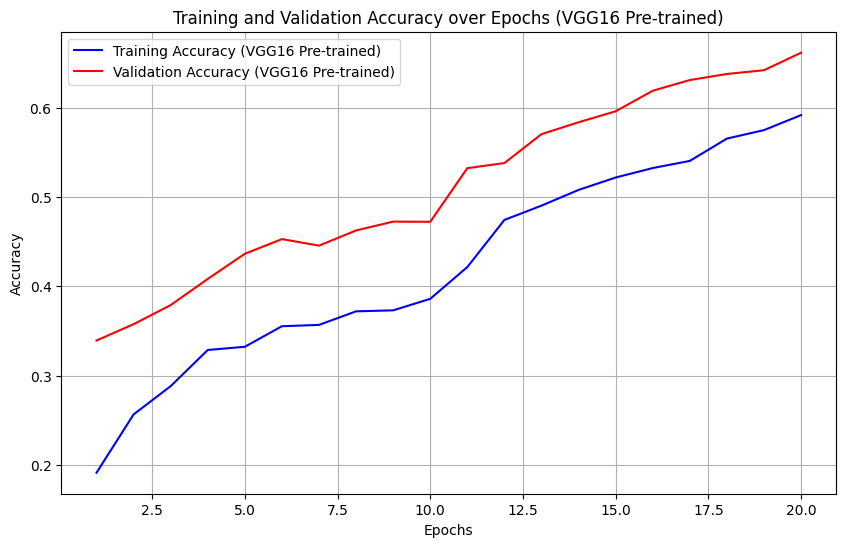

In [ ]:
#Accuracy plot for VGG16 with pre-trained weights

import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 21))

# Training and validation accuracy for each epoch (first and second run)
train_accuracy = [0.1911, 0.2564, 0.2881, 0.3286, 0.3322, 0.3552, 0.3567, 0.3719, 0.3730, 0.3859,
                  0.4215, 0.4743, 0.4903, 0.5079, 0.5218, 0.5324, 0.5404, 0.5654, 0.5749, 0.5917]
val_accuracy = [0.3392, 0.3575, 0.3789, 0.4082, 0.4364, 0.4528, 0.4455, 0.4625, 0.4724, 0.4722,
                0.5323, 0.5380, 0.5704, 0.5837, 0.5960, 0.6190, 0.6310, 0.6378, 0.6420, 0.6616]

# Plotting the accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy (VGG16 Pre-trained)', color='blue')
plt.plot(epochs, val_accuracy, label='Validation Accuracy (VGG16 Pre-trained)' , color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (VGG16 Pre-trained)')
plt.legend()
plt.grid(True)
plt.show()


VGG16 - Pre-trained

Epoch 1/10
122/122 [==============================] - 76s 621ms/step - loss: 2.9750 - accuracy: 0.1911 - val_loss: 1.9624 - val_accuracy: 0.3392
Epoch 2/10
122/122 [==============================] - 127s 1s/step - loss: 2.5219 - accuracy: 0.2564 - val_loss: 1.9640 - val_accuracy: 0.3575
Epoch 3/10
122/122 [==============================] - 132s 1s/step - loss: 2.3783 - accuracy: 0.2881 - val_loss: 1.9160 - val_accuracy: 0.3789
Epoch 4/10
122/122 [==============================] - 121s 995ms/step - loss: 2.1973 - accuracy: 0.3286 - val_loss: 1.7745 - val_accuracy: 0.4082
Epoch 5/10
122/122 [==============================] - 119s 982ms/step - loss: 2.0846 - accuracy: 0.3322 - val_loss: 1.6841 - val_accuracy: 0.4364
Epoch 6/10
122/122 [==============================] - 127s 1s/step - loss: 2.0145 - accuracy: 0.3552 - val_loss: 1.6454 - val_accuracy: 0.4528
Epoch 7/10
122/122 [==============================] - 118s 968ms/step - loss: 1.9539 - accuracy: 0.3567 - val_loss: 1.6795 - val_accuracy: 0.4455
Epoch 8/10
122/122 [==============================] - 118s 971ms/step - loss: 1.9209 - accuracy: 0.3719 - val_loss: 1.6562 - val_accuracy: 0.4625
Epoch 9/10
122/122 [==============================] - 124s 1s/step - loss: 1.8717 - accuracy: 0.3730 - val_loss: 1.5955 - val_accuracy: 0.4724
Epoch 10/10
122/122 [==============================] - 137s 1s/step - loss: 1.8039 - accuracy: 0.3859 - val_loss: 1.5727 - val_accuracy: 0.4722
Epoch 1/10
122/122 [==============================] - 156s 1s/step - loss: 1.7250 - accuracy: 0.4215 - val_loss: 1.4135 - val_accuracy: 0.5323
Epoch 2/10
122/122 [==============================] - 160s 1s/step - loss: 1.6320 - accuracy: 0.4743 - val_loss: 1.4019 - val_accuracy: 0.5380
Epoch 3/10
122/122 [==============================] - 161s 1s/step - loss: 1.5995 - accuracy: 0.4903 - val_loss: 1.2935 - val_accuracy: 0.5704
Epoch 4/10
122/122 [==============================] - 142s 1s/step - loss: 1.5338 - accuracy: 0.5079 - val_loss: 1.2847 - val_accuracy: 0.5837
Epoch 5/10
122/122 [==============================] - 140s 1s/step - loss: 1.4832 - accuracy: 0.5218 - val_loss: 1.2433 - val_accuracy: 0.5960
Epoch 6/10
122/122 [==============================] - 117s 957ms/step - loss: 1.5001 - accuracy: 0.5324 - val_loss: 1.1871 - val_accuracy: 0.6190
Epoch 7/10
122/122 [==============================] - 117s 964ms/step - loss: 1.4539 - accuracy: 0.5404 - val_loss: 1.1509 - val_accuracy: 0.6310
Epoch 8/10
122/122 [==============================] - 119s 979ms/step - loss: 1.3911 - accuracy: 0.5654 - val_loss: 1.1418 - val_accuracy: 0.6378
Epoch 9/10
122/122 [==============================] - 119s 977ms/step - loss: 1.3781 - accuracy: 0.5749 - val_loss: 1.1230 - val_accuracy: 0.6420
Epoch 10/10
122/122 [==============================] - 118s 967ms/step - loss: 1.2987 - accuracy: 0.5917 - val_loss: 1.1116 - val_accuracy: 0.6616
120/120 [==============================] - 53s 443ms/step - loss: 1.1116 - accuracy: 0.6616
Test accuracy: 66.16%

### Comparison Of Accuracy Scores Between Models

In [ ]:
models = ['AlexNet (No Pretrained)', 'AlexNet (Pretrained)', 'VGG16 (No Pretrained)', 'VGG16 (Pretrained)']
accuracy_vgg16i = 0.66 #This is done just to be consistent with other data, since the training takes place in different computers
accuracies = [accuracy_alexnetd * 100, accuracy_alexneti * 100, accuracy_vgg16d * 100, accuracy_vgg16i * 100]

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'orange'])
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.ylim([0, 100])

for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', va='bottom')

plt.show()

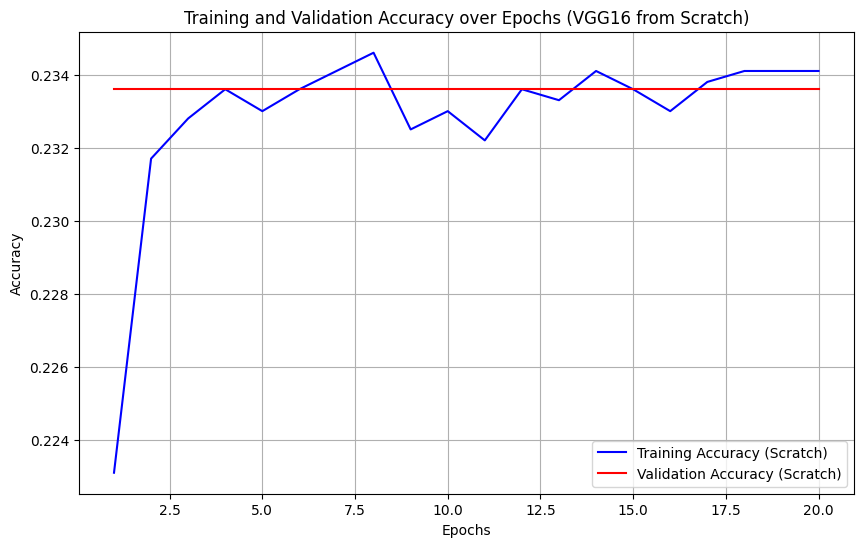

In [ ]:
#Accuracy plot for VGG16 from scratch

import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 21))

# Training and validation accuracy for each epoch for the VGG16 trained from scratch
train_accuracy_scratch = [
    0.2231, 0.2317, 0.2328, 0.2336, 0.2330, 0.2336, 0.2341, 0.2346, 0.2325, 0.2330,
    0.2322, 0.2336, 0.2333, 0.2341, 0.2336, 0.2330, 0.2338, 0.2341, 0.2341, 0.2341
]
val_accuracy_scratch = [
    0.2336, 0.2336, 0.2336, 0.2336, 0.2336, 0.2336, 0.2336, 0.2336, 0.2336, 0.2336,
    0.2336, 0.2336, 0.2336, 0.2336, 0.2336, 0.2336, 0.2336, 0.2336, 0.2336, 0.2336
]

# Plotting the accuracy for VGG16 trained from scratch
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy_scratch, label='Training Accuracy (Scratch)', color='blue')
plt.plot(epochs, val_accuracy_scratch, label='Validation Accuracy (Scratch)', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (VGG16 from Scratch)')
plt.legend()
plt.grid(True)
plt.show()


VGG16 Scratch

Epoch 1/10
121/121 [==============================] - 207s 2s/step - loss: 2.1491 - accuracy: 0.2231 - val_loss: 2.1255 - val_accuracy: 0.2336
Epoch 2/10
121/121 [==============================] - 244s 2s/step - loss: 2.1308 - accuracy: 0.2317 - val_loss: 2.1202 - val_accuracy: 0.2336
Epoch 3/10
121/121 [==============================] - 659s 5s/step - loss: 2.1271 - accuracy: 0.2328 - val_loss: 2.1204 - val_accuracy: 0.2336
Epoch 4/10
121/121 [==============================] - 207s 2s/step - loss: 2.1252 - accuracy: 0.2336 - val_loss: 2.1239 - val_accuracy: 0.2336
Epoch 5/10
121/121 [==============================] - 244s 2s/step - loss: 2.1263 - accuracy: 0.2330 - val_loss: 2.1205 - val_accuracy: 0.2336
Epoch 6/10
121/121 [==============================] - 2800s 23s/step - loss: 2.1225 - accuracy: 0.2336 - val_loss: 2.1232 - val_accuracy: 0.2336
Epoch 7/10
121/121 [==============================] - 206s 2s/step - loss: 2.1207 - accuracy: 0.2341 - val_loss: 2.1179 - val_accuracy: 0.2336
Epoch 8/10
121/121 [==============================] - 243s 2s/step - loss: 2.1213 - accuracy: 0.2346 - val_loss: 2.1213 - val_accuracy: 0.2336
Epoch 9/10
121/121 [==============================] - 254s 2s/step - loss: 2.1235 - accuracy: 0.2325 - val_loss: 2.1193 - val_accuracy: 0.2336
Epoch 10/10
121/121 [==============================] - 259s 2s/step - loss: 2.1197 - accuracy: 0.2330 - val_loss: 2.1280 - val_accuracy: 0.2336
Epoch 1/10
121/121 [==============================] - 276s 2s/step - loss: 2.1222 - accuracy: 0.2322 - val_loss: 2.1175 - val_accuracy: 0.2336
Epoch 2/10
121/121 [==============================] - 313s 3s/step - loss: 2.1202 - accuracy: 0.2336 - val_loss: 2.1183 - val_accuracy: 0.2336
Epoch 3/10
121/121 [==============================] - 326s 3s/step - loss: 2.1209 - accuracy: 0.2333 - val_loss: 2.1182 - val_accuracy: 0.2336
Epoch 4/10
121/121 [==============================] - 332s 3s/step - loss: 2.1181 - accuracy: 0.2341 - val_loss: 2.1195 - val_accuracy: 0.2336
Epoch 5/10
121/121 [==============================] - 341s 3s/step - loss: 2.1190 - accuracy: 0.2336 - val_loss: 2.1172 - val_accuracy: 0.2336
Epoch 6/10
121/121 [==============================] - 351s 3s/step - loss: 2.1193 - accuracy: 0.2330 - val_loss: 2.1189 - val_accuracy: 0.2336
Epoch 7/10
121/121 [==============================] - 357s 3s/step - loss: 2.1171 - accuracy: 0.2338 - val_loss: 2.1152 - val_accuracy: 0.2336
Epoch 8/10
121/121 [==============================] - 376s 3s/step - loss: 2.1170 - accuracy: 0.2341 - val_loss: 2.1174 - val_accuracy: 0.2336
Epoch 9/10
121/121 [==============================] - 362s 3s/step - loss: 2.1138 - accuracy: 0.2341 - val_loss: 2.1181 - val_accuracy: 0.2336
Epoch 10/10
121/121 [==============================] - 364s 3s/step - loss: 2.1163 - accuracy: 0.2341 - val_loss: 2.1174 - val_accuracy: 0.2336
120/120 [==============================] - 73s 610ms/step - loss: 2.1174 - accuracy: 0.2336
Test accuracy: 23.36%

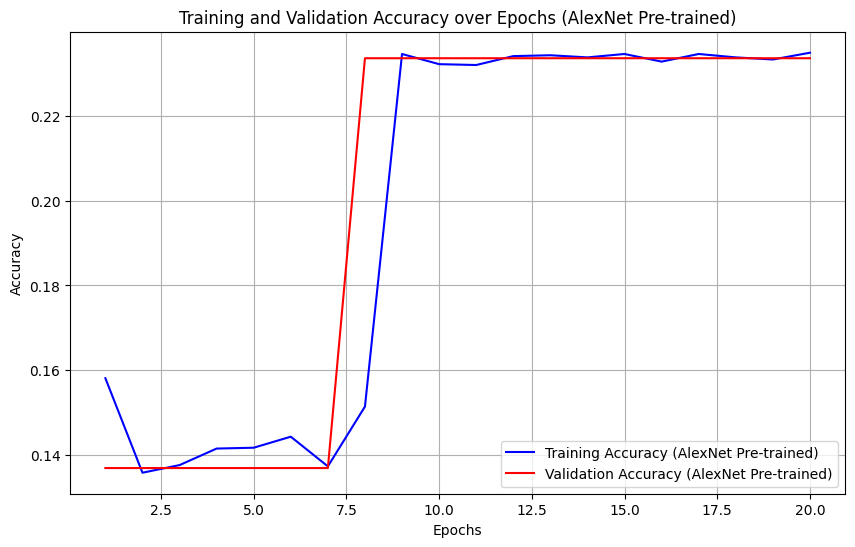

In [ ]:
#Accuracy plot for AlexNet with pre-trained weights

import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 21))

# Training and validation accuracy for each epoch for the AlexNet pre-trained model
train_accuracy_alexnet = [
    0.1581, 0.1358, 0.1376, 0.1415, 0.1417, 0.1443, 0.1373, 0.1514, 0.2346, 0.2322,
    0.2320, 0.2341, 0.2343, 0.2338, 0.2346, 0.2328, 0.2346, 0.2338, 0.2333, 0.2349
]
val_accuracy_alexnet = [
    0.1369, 0.1369, 0.1369, 0.1369, 0.1369, 0.1369, 0.1369, 0.2336, 0.2336, 0.2336,
    0.2336, 0.2336, 0.2336, 0.2336, 0.2336, 0.2336, 0.2336, 0.2336, 0.2336, 0.2336
]

# Plotting the accuracy for AlexNet pre-trained model
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy_alexnet, label='Training Accuracy (AlexNet Pre-trained)', color='blue')
plt.plot(epochs, val_accuracy_alexnet, label='Validation Accuracy (AlexNet Pre-trained)', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (AlexNet Pre-trained)')
plt.legend()
plt.grid(True)
plt.show()


AlexNet - Pre-trained

Epoch 1/10
121/121 [==============================] - 31s 249ms/step - loss: 2.3025 - accuracy: 0.1581 - val_loss: 2.2997 - val_accuracy: 0.1369
Epoch 2/10
121/121 [==============================] - 30s 249ms/step - loss: 2.2941 - accuracy: 0.1358 - val_loss: 2.2892 - val_accuracy: 0.1369
Epoch 3/10
121/121 [==============================] - 30s 247ms/step - loss: 2.2845 - accuracy: 0.1376 - val_loss: 2.2798 - val_accuracy: 0.1369
Epoch 4/10
121/121 [==============================] - 30s 250ms/step - loss: 2.2756 - accuracy: 0.1415 - val_loss: 2.2709 - val_accuracy: 0.1369
Epoch 5/10
121/121 [==============================] - 30s 245ms/step - loss: 2.2670 - accuracy: 0.1417 - val_loss: 2.2626 - val_accuracy: 0.1369
Epoch 6/10
121/121 [==============================] - 30s 250ms/step - loss: 2.2584 - accuracy: 0.1443 - val_loss: 2.2546 - val_accuracy: 0.1369
Epoch 7/10
121/121 [==============================] - 30s 249ms/step - loss: 2.2514 - accuracy: 0.1373 - val_loss: 2.2470 - val_accuracy: 0.1369
Epoch 8/10
121/121 [==============================] - 31s 251ms/step - loss: 2.2441 - accuracy: 0.1514 - val_loss: 2.2400 - val_accuracy: 0.2336
Epoch 9/10
121/121 [==============================] - 31s 256ms/step - loss: 2.2372 - accuracy: 0.2346 - val_loss: 2.2332 - val_accuracy: 0.2336
Epoch 10/10
121/121 [==============================] - 31s 260ms/step - loss: 2.2308 - accuracy: 0.2322 - val_loss: 2.2268 - val_accuracy: 0.2336
Epoch 1/10
121/121 [==============================] - 36s 290ms/step - loss: 2.2276 - accuracy: 0.2320 - val_loss: 2.2261 - val_accuracy: 0.2336
Epoch 2/10
121/121 [==============================] - 36s 301ms/step - loss: 2.2260 - accuracy: 0.2341 - val_loss: 2.2254 - val_accuracy: 0.2336
Epoch 3/10
121/121 [==============================] - 35s 290ms/step - loss: 2.2262 - accuracy: 0.2343 - val_loss: 2.2248 - val_accuracy: 0.2336
Epoch 4/10
121/121 [==============================] - 35s 287ms/step - loss: 2.2250 - accuracy: 0.2338 - val_loss: 2.2241 - val_accuracy: 0.2336
Epoch 5/10
121/121 [==============================] - 35s 292ms/step - loss: 2.2247 - accuracy: 0.2346 - val_loss: 2.2235 - val_accuracy: 0.2336
Epoch 6/10
121/121 [==============================] - 41s 339ms/step - loss: 2.2238 - accuracy: 0.2328 - val_loss: 2.2229 - val_accuracy: 0.2336
Epoch 7/10
121/121 [==============================] - 39s 321ms/step - loss: 2.2225 - accuracy: 0.2346 - val_loss: 2.2222 - val_accuracy: 0.2336
Epoch 8/10
121/121 [==============================] - 36s 300ms/step - loss: 2.2225 - accuracy: 0.2338 - val_loss: 2.2216 - val_accuracy: 0.2336
Epoch 9/10
121/121 [==============================] - 35s 287ms/step - loss: 2.2220 - accuracy: 0.2333 - val_loss: 2.2210 - val_accuracy: 0.2336
Epoch 10/10
121/121 [==============================] - 34s 282ms/step - loss: 2.2216 - accuracy: 0.2349 - val_loss: 2.2203 - val_accuracy: 0.2336
120/120 [==============================] - 9s 71ms/step - loss: 2.2203 - accuracy: 0.2336
Test accuracy: 23.36%

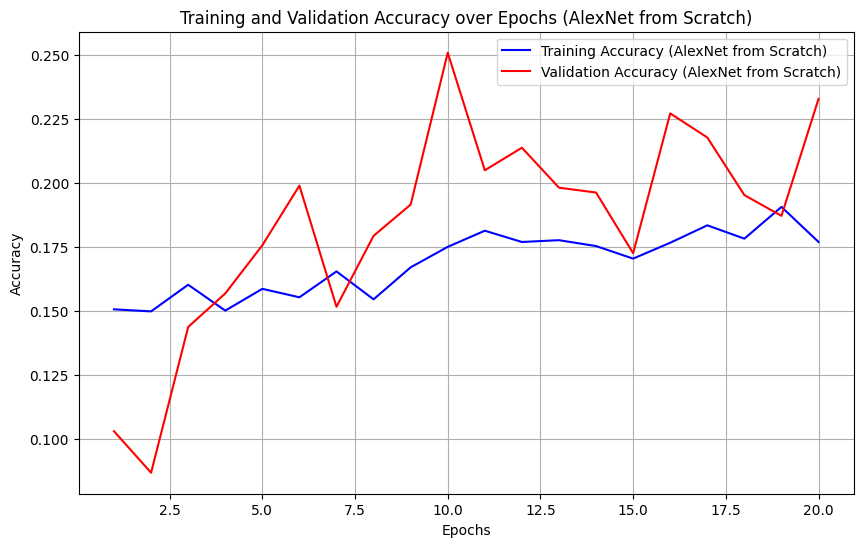

In [ ]:
#Accuracy plot for AlexNet from scratch

import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 21))

# Training and validation accuracy for each epoch for the AlexNet model trained from scratch
train_accuracy_alexnet_scratch = [
    0.1506, 0.1498, 0.1602, 0.1501, 0.1586, 0.1553, 0.1654, 0.1545, 0.1670, 0.1750,
    0.1813, 0.1769, 0.1776, 0.1753, 0.1704, 0.1766, 0.1834, 0.1782, 0.1906, 0.1769
]
val_accuracy_alexnet_scratch = [
    0.1030, 0.0868, 0.1437, 0.1568, 0.1756, 0.1989, 0.1516, 0.1793, 0.1915, 0.2508,
    0.2049, 0.2137, 0.1981, 0.1962, 0.1725, 0.2271, 0.2177, 0.1952, 0.1871, 0.2328
]

# Plotting the accuracy for AlexNet model trained from scratch
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy_alexnet_scratch, label='Training Accuracy (AlexNet from Scratch)', color='blue')
plt.plot(epochs, val_accuracy_alexnet_scratch, label='Validation Accuracy (AlexNet from Scratch)', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs (AlexNet from Scratch)')
plt.legend()
plt.grid(True)
plt.show()


AlexNet Scratch

Epoch 1/10
121/121 [==============================] - 40s 314ms/step - loss: 7.3903 - accuracy: 0.1506 - val_loss: 2.7186 - val_accuracy: 0.1030
Epoch 2/10
121/121 [==============================] - 38s 314ms/step - loss: 6.5072 - accuracy: 0.1498 - val_loss: 2.9635 - val_accuracy: 0.0868
Epoch 3/10
121/121 [==============================] - 39s 324ms/step - loss: 5.4171 - accuracy: 0.1602 - val_loss: 3.0717 - val_accuracy: 0.1437
Epoch 4/10
121/121 [==============================] - 42s 347ms/step - loss: 4.8660 - accuracy: 0.1501 - val_loss: 3.0270 - val_accuracy: 0.1568
Epoch 5/10
121/121 [==============================] - 42s 350ms/step - loss: 4.4544 - accuracy: 0.1586 - val_loss: 3.1286 - val_accuracy: 0.1756
Epoch 6/10
121/121 [==============================] - 50s 412ms/step - loss: 4.3355 - accuracy: 0.1553 - val_loss: 3.3621 - val_accuracy: 0.1989
Epoch 7/10
121/121 [==============================] - 54s 445ms/step - loss: 4.3542 - accuracy: 0.1654 - val_loss: 3.2962 - val_accuracy: 0.1516
Epoch 8/10
121/121 [==============================] - 51s 425ms/step - loss: 4.3153 - accuracy: 0.1545 - val_loss: 4.0501 - val_accuracy: 0.1793
Epoch 9/10
121/121 [==============================] - 54s 447ms/step - loss: 4.2012 - accuracy: 0.1670 - val_loss: 3.8811 - val_accuracy: 0.1915
Epoch 10/10
121/121 [==============================] - 53s 434ms/step - loss: 4.2074 - accuracy: 0.1750 - val_loss: 2.7622 - val_accuracy: 0.2508
Epoch 1/10
121/121 [==============================] - 55s 447ms/step - loss: 3.7852 - accuracy: 0.1813 - val_loss: 3.2319 - val_accuracy: 0.2049
Epoch 2/10
121/121 [==============================] - 54s 447ms/step - loss: 3.5254 - accuracy: 0.1769 - val_loss: 3.1350 - val_accuracy: 0.2137
Epoch 3/10
121/121 [==============================] - 54s 447ms/step - loss: 3.4029 - accuracy: 0.1776 - val_loss: 3.3468 - val_accuracy: 0.1981
Epoch 4/10
121/121 [==============================] - 55s 449ms/step - loss: 3.3396 - accuracy: 0.1753 - val_loss: 3.1912 - val_accuracy: 0.1962
Epoch 5/10
121/121 [==============================] - 55s 454ms/step - loss: 3.3986 - accuracy: 0.1704 - val_loss: 3.2078 - val_accuracy: 0.1725
Epoch 6/10
121/121 [==============================] - 57s 472ms/step - loss: 3.3516 - accuracy: 0.1766 - val_loss: 2.8074 - val_accuracy: 0.2271
Epoch 7/10
121/121 [==============================] - 60s 495ms/step - loss: 3.2600 - accuracy: 0.1834 - val_loss: 2.9522 - val_accuracy: 0.2177
Epoch 8/10
121/121 [==============================] - 57s 471ms/step - loss: 3.2020 - accuracy: 0.1782 - val_loss: 3.1228 - val_accuracy: 0.1952
Epoch 9/10
121/121 [==============================] - 57s 472ms/step - loss: 3.0993 - accuracy: 0.1906 - val_loss: 3.1528 - val_accuracy: 0.1871
Epoch 10/10
121/121 [==============================] - 57s 469ms/step - loss: 3.1448 - accuracy: 0.1769 - val_loss: 2.8738 - val_accuracy: 0.2328
120/120 [==============================] - 15s 125ms/step - loss: 2.8738 - accuracy: 0.2328
Test accracy: 23.28

### Plotting All The Models Confusion Matrix

In [ ]:
import numpy as np

true_labels_alexnet = test_generator_alexnet.classes
true_labels_vgg16 = test_generator_vgg16.classes

#Generate predictions for each model
predictions_alexnetd = np.argmax(alexnetd_model.predict(test_generator_alexnet), axis=1)
predictions_alexneti = np.argmax(alexneti_model.predict(test_generator_alexnet), axis=1)
predictions_vgg16d = np.argmax(vgg16d_model.predict(test_generator_vgg16), axis=1)
predictions_vgg16i = np.argmax(vgg16i_model.predict(test_generator_vgg16), axis=1)

# Create confusion matrices
conf_matrix_alexnetd = confusion_matrix(true_labels_alexnet, predictions_alexnetd)
conf_matrix_alexneti = confusion_matrix(true_labels_alexnet, predictions_alexneti)
conf_matrix_vgg16d = confusion_matrix(true_labels_vgg16, predictions_vgg16d)
conf_matrix_vgg16i = confusion_matrix(true_labels_vgg16, predictions_vgg16i)



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix
conf_matrix_alexnetd = confusion_matrix(true_labels_alexnet, predictions_alexnetd)

# Plot confusion matrix
plt.figure(figsize=(12, 10))  # Increase the figsize to make the plot larger
disp = ConfusionMatrixDisplay(conf_matrix_alexnetd, display_labels=test_generator_alexnet.class_indices.keys())
disp.plot(xticks_rotation='vertical')
plt.title('Confusion Matrix: AlexNet (No Pretrained)')
plt.show()


In [ ]:
conf_matrix_alexneti = confusion_matrix(true_labels_alexnet, predictions_alexneti)

# Plot confusion matrix
plt.figure(figsize=(12, 10))  # Increase the figsize to make the plot larger
disp = ConfusionMatrixDisplay(conf_matrix_alexneti, display_labels=test_generator_alexnet.class_indices.keys())
disp.plot( xticks_rotation='vertical')
plt.title('Confusion Matrix: AlexNet (Pretrained)')
plt.show()

In [ ]:
conf_matrix_vgg16d = confusion_matrix(true_labels_vgg16, predictions_vgg16d)

# Plot confusion matrix
plt.figure(figsize=(12, 10))  # Increase the figsize to make the plot larger
disp = ConfusionMatrixDisplay(conf_matrix_vgg16d, display_labels=test_generator_vgg16.class_indices.keys())
disp.plot( xticks_rotation='vertical')
plt.title('Confusion Matrix: VGG16 (No Pretrained)')
plt.show()

In [ ]:
conf_matrix_vgg16i = confusion_matrix(true_labels_vgg16, predictions_vgg16i)

# Plot confusion matrix
plt.figure(figsize=(12, 10))  # Increase the figsize to make the plot larger
disp = ConfusionMatrixDisplay(conf_matrix_vgg16i, display_labels=test_generator_vgg16.class_indices.keys())
disp.plot(xticks_rotation='vertical')
plt.title('Confusion Matrix: VGG16 (Pretrained)')
plt.show()